In [13]:
import pandas as pd
import numpy as np
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
import dash
import plotly.express as px
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from aif360.datasets import CompasDataset, BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from fpdf import FPDF

2025-07-10 16:56:42.034467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 16:56:43.748272: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 16:56:44.347920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752155805.863663    5501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752155805.999185    5501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752155807.514791    5501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
compas = pd.read_csv("/home/jeremy/Documents/PLP/week-seven-ai-ethics/compas-bias-audit/data/compas-scores.csv")
compas = janitor.clean_names(compas)
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score_1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [3]:
pd.DataFrame(compas["decile_score"].value_counts()) \
    .sort_index().reset_index() \
        # .rename(columns={"index": "decile_score", "decile_score": "count"}) \
        #     .sort_values(by="decile_score", ascending=True)

,decile_score,count
0,-1,15
1,1,2577
2,2,1572
3,3,1259
4,4,1199
5,5,1034
6,6,993
7,7,900
8,8,796
9,9,802


In [4]:
compas.shape

(11757, 47)

In [5]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [6]:
compas.columns.sort_values(ascending=True)

Index(['age', 'age_cat', 'c_arrest_date', 'c_case_number', 'c_charge_degree',
       'c_charge_desc', 'c_days_from_compas', 'c_jail_in', 'c_jail_out',
       'c_offense_date', 'compas_screening_date', 'days_b_screening_arrest',
       'decile_score', 'decile_score_1', 'dob', 'first', 'id', 'is_recid',
       'is_violent_recid', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'last', 'name', 'num_r_cases', 'num_vr_cases',
       'priors_count', 'r_case_number', 'r_charge_degree', 'r_charge_desc',
       'r_days_from_arrest', 'r_jail_in', 'r_jail_out', 'r_offense_date',
       'race', 'score_text', 'screening_date', 'sex', 'type_of_assessment',
       'v_decile_score', 'v_score_text', 'v_screening_date',
       'v_type_of_assessment', 'vr_case_number', 'vr_charge_degree',
       'vr_charge_desc', 'vr_offense_date'],
      dtype='object')

In [7]:
compas["race"].value_counts()

race
African-American    5813
Caucasian           4085
Hispanic            1100
Other                661
Asian                 58
Native American       40
Name: count, dtype: int64

In [8]:
compas['type_of_assessment'].value_counts()

type_of_assessment
Risk of Recidivism    11757
Name: count, dtype: int64

In [9]:
compas['age_cat'].value_counts()

age_cat
25 - 45            6649
Greater than 45    2668
Less than 25       2440
Name: count, dtype: int64

In [10]:
compas['score_text'].value_counts()

score_text
Low       6607
Medium    2927
High      2208
Name: count, dtype: int64

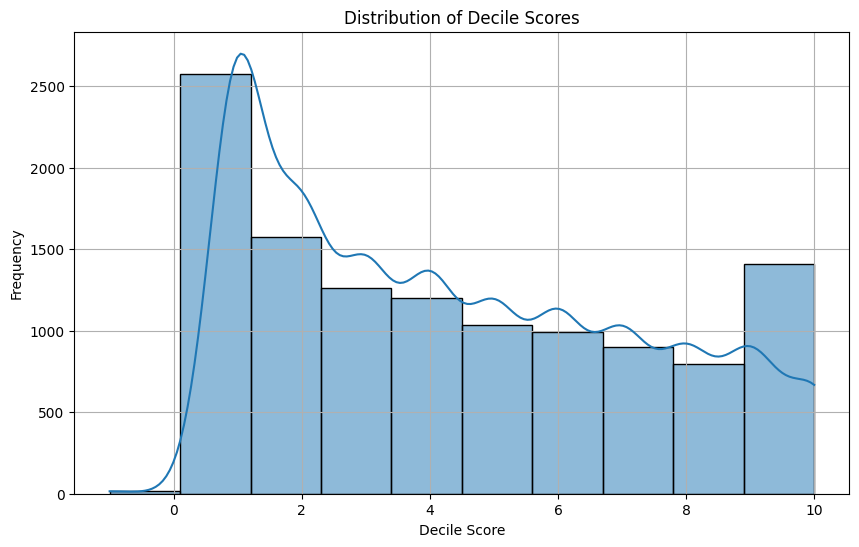

In [11]:
# plot a histogram of the decile scores using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compas['decile_score'], bins=10, kde=True)
plt.title('Distribution of Decile Scores')
plt.xlabel('Decile Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

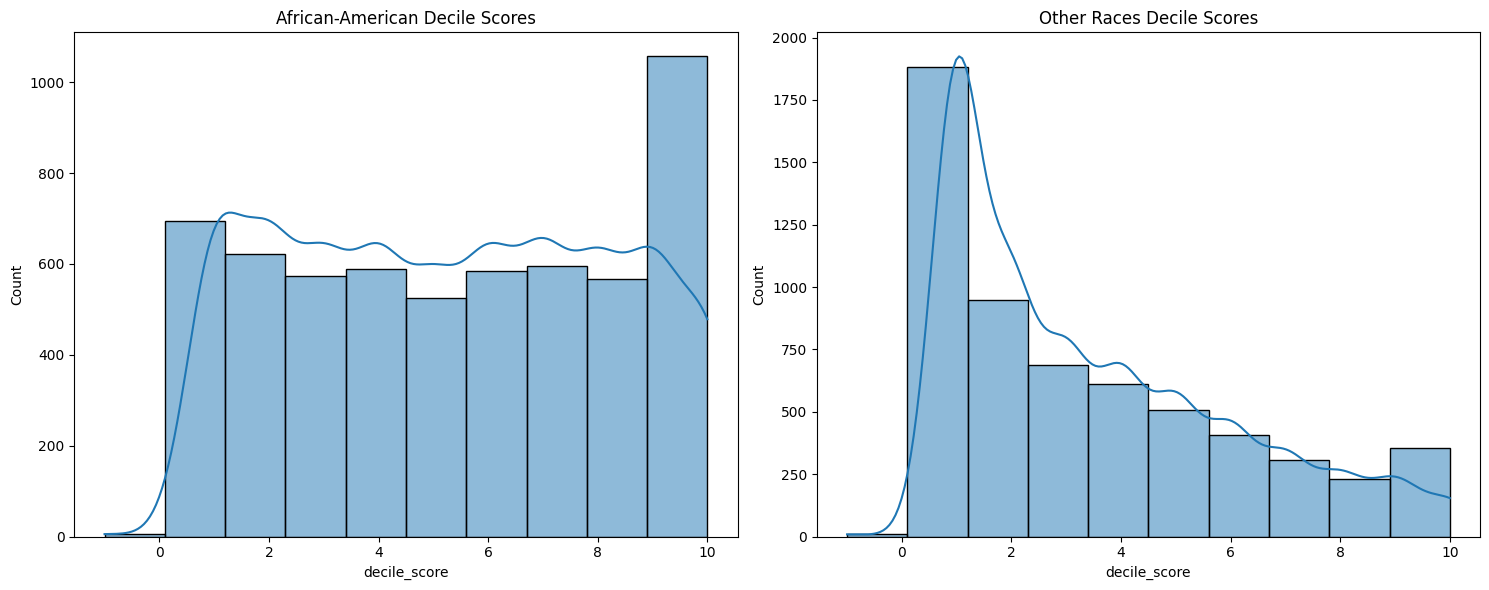

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# African-American
sns.histplot(compas[compas['race'] == 'African-American']['decile_score'], bins=10, kde=True, ax=ax[0])
ax[0].set_title('African-American Decile Scores')

# White and other races
sns.histplot(compas[compas['race'].isin(['Caucasian', 'Hispanic', 'Other', 'Asian', 'Native American'])]['decile_score'], bins=10, kde=True, ax=ax[1])
ax[1].set_title('Other Races Decile Scores')

plt.tight_layout()
plt.show()